<center><span style="font-size:25px;">ПРЕДСКАЗАНИЕ МЕДИЦИНСКОЙ СТРАХОВКИ</span></center>

Работать будем с популярным датасетом [Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance).

Набор данных содержит следующие столбцы:

<table style="width: 70%; padding: 0.2em; border-collapse: collapse; margin: 0px auto; border: 1px solid #b0b0b0;">
<tbody>
<tr>
<td style="width: 20%; text-align: center; vertical-align: middle; background-color: #10564f; border: 1px solid #b0b0b0; padding: 0.2em;"><span style="color: #ffffff;">Признак</span></td>
<td style="width: 80%; text-align: center; vertical-align: middle; background-color: #10564f; border: 1px solid #b0b0b0; padding: 0.2em;"><span style="color: #ffffff;">Описание</span></td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">age</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">возраст страхователя</td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">sex</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">пол</td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">bmi</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">индекс массы тела (кгм), в идеале — от 18.5 до 24.9</td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">children</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">количество детей, охваченных медицинской страховкой</td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">smoker</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">является ли человек курящим</td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">region</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад)</td>
</tr>
<tr>
<td style="width: 20%; text-align: center; border: 1px solid #b0b0b0; padding: 0.2em;">charges<br />(<span style='color:red'>целевой</span>)</td>
<td style="width: 80%; text-align: left; border: 1px solid #b0b0b0; padding: 0.2em;">индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.</td>
</tr>
</tbody>
</table>
<br />

<img src='data/pics/ml2pic88practice.png' width=70% style='display:block; margin:auto;'>

Проект был сделан на `Python 3.11.6`

<h2 id='contents'>Оглавляшка:</h2>

* [Загружаемые библиотеки](#libs)
* [Загрузка данных](#loaddata)
* [Небольшой EDA](#littleeda)
* [Кодирование признаков и разделение на train и test](#traintestscaling)

Моделирование:

* [Простая линейная регрессия](#linreg)
* [Нормализация и создание полиномиальных признаков](#minmaxvspoly)
* [Линейная регрессия на полиномиальных признаках](#linregpoly)
* [Lasso регрессия на полиномиальных признаках](#lassopoly)
* [Ridge регрессия на полиномиальных признаках](#ridgepoly)

Дополнительнео исследование:

* [RidgeCV регрессия на полиномиальных признаках и логарифмированном таргете](#ridgepolylogtarget)

## Загружаемые библиотеки<a id='libs'></a>

In [1]:
from data.functions_akialema import *

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns

from sklearn import linear_model 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

## Загрузка данных<a id='loaddata'></a>

In [2]:
incoming_df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1QsXkzehujKHHSk7om0umD8xFhMwysx96')

my_info(incoming_df)

memory usage: 293.4 KB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,sex,2,object,male,1338,0,1,type obj
1,smoker,2,object,no,1338,0,1,type obj
2,region,4,object,southeast,1338,0,1,type obj
3,children,6,int64,0,1338,0,1,min:... 0.00max:.. 5.00mean: 1.09std:.... 1.21
4,age,47,int64,18,1338,0,1,min:... 18.00max:.. 64.00mean: 39.21std:.... 14.05
5,bmi,548,float64,32.3,1338,0,1,min:... 15.96max:.. 53.13mean: 30.66std:.... 6.10
6,charges,1337,float64,1639.56,1338,0,1,min:... 1121.87max:.. 63770.43mean: 13270.42std:.... 12110.01


## Небольшой разведывательный анализ<a id='littleeda'></a>

[↑ contents](#contents)

In [3]:
insurance_df = incoming_df.copy()

Взгляну на гистограммы признаков и на зависимость каждого признака от целевого.

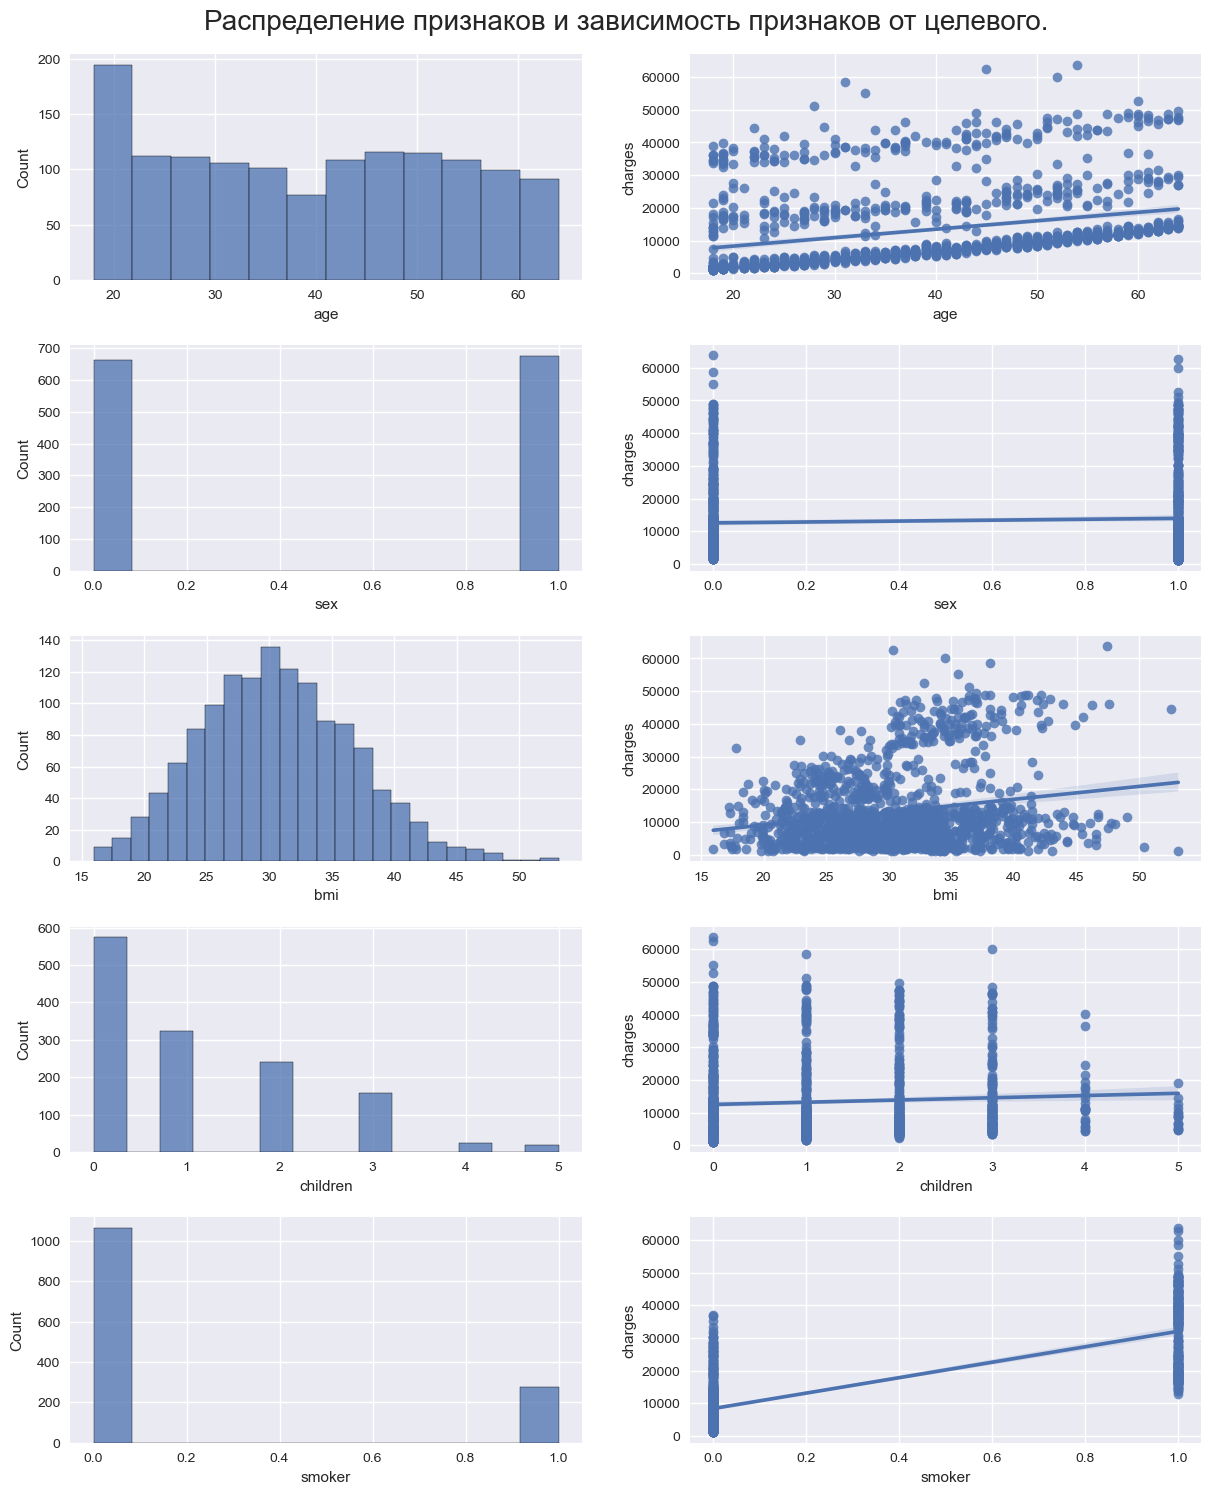

In [4]:
df_for_this_cell = insurance_df.assign(smoker=insurance_df['smoker'].apply(lambda x: 1 if x == 'yes' else 0),
                                       sex=insurance_df['sex'].apply(lambda x: 1 if x == 'male' else 0)).select_dtypes(include='number')

fig, ax = plt.subplots(nrows=len(df_for_this_cell.columns)-1, ncols=2, figsize=(12, 15))

fig.tight_layout(w_pad=5, h_pad=3) # расстояние между подграфиками
plt.subplots_adjust(top=0.95) # чтобы заголовок не налезал на графики

plt.suptitle('Распределение признаков и зависимость признаков от целевого.').set_fontsize(20)

for i, feature in enumerate(df_for_this_cell):
    if feature != 'charges':
        sns.histplot(data=df_for_this_cell, x=feature, ax=ax[i, 0])
        sns.regplot(data=df_for_this_cell, x=feature, y='charges', ax=ax[i, 1])

plt.show()

- Наблюдается доминирование возраста 20 лет. Признак имеет слабую линейную зависимость от целевого признака;
- Наблюдается почти одинаковое количество женщин и мужчин;
- Признак bmi распределён практически нормально и имеет слабую линейную зависимость от целевого признака;
- В данных преобладает количество наблюдений, в которых, в признаки "дети" - 0;
- Курильщиков больше, чем противоположной категории и данный признак имеет приличную линейную зависимость относительно целевого.

Взгляну на вот такую интересную диаграмму:

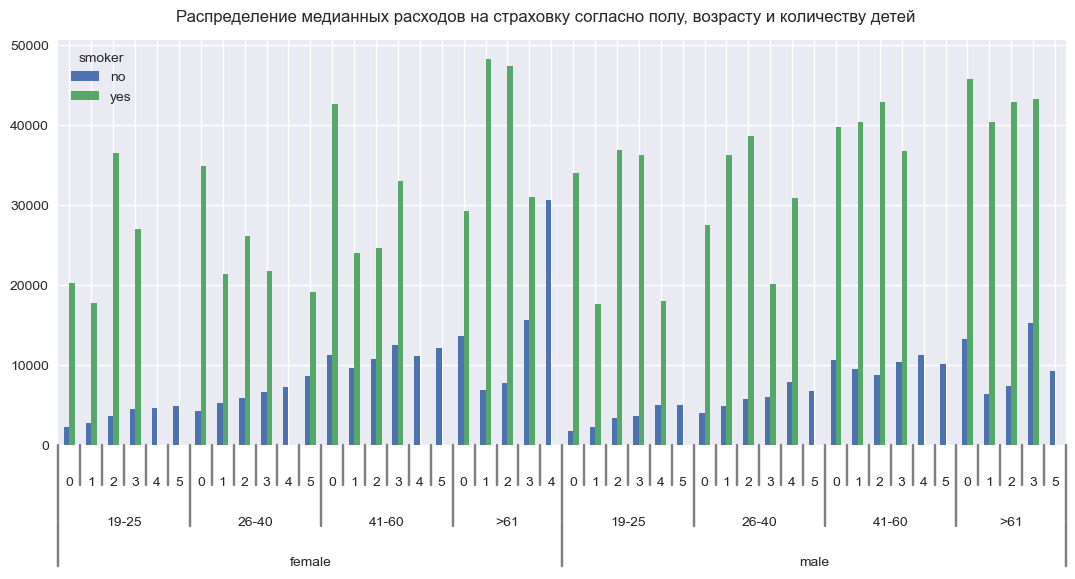

In [5]:
fig, ax = plt.subplots(figsize=(13, 5))

plt.subplots_adjust(top=0.92) # чтобы заголовок не налезал на графики

df_for_this_cell = incoming_df.copy()
df_for_this_cell['age'] = incoming_df['age'].apply(lambda x: '19-25' if 10 < x <= 25 else '26-40' if 26 < x <= 40 else '41-60' if 41 < x <= 60 else '>61')

df_for_this_cell = df_for_this_cell.groupby(['sex', 'age', 'children', 'smoker'])['charges'].median().unstack()
df_for_this_cell.plot(kind='bar', stacked=False, ax=ax)

ax.set_xticklabels('') # удаление названий по оси х.
ax.set_xlabel('')
label_group_bar_table(ax, df_for_this_cell)

plt.suptitle('Распределение медианных расходов на страховку согласно полу, возрасту и количеству детей')

plt.show()

Что интересно:
- в женской подгруппе наблюдается почти линейный рост расходов на страховку в зависимости от возраста;
- в мужской группе почти то же самое, только несколько меньше;
- в обеих половых группах и возрастных категориях, люди, у которых 4-5 детей - не курят!)
- у курильщиков нет явного линейного роста, в зависимости от возраста (в разрезе наличия детей, разумеется, так то там есть линейный рост, если убрать детей)
- ну и в основном больше всего расходов несут, естественно, пожилые курильщики.

## Кодирование признаков и разделение на train и test<a id='traintestscaling'></a>

[↑ contents](#contents)

In [6]:
model_df = incoming_df.copy()

model_df['sex'] = model_df['sex'].apply(lambda x: 1 if x == 'male' else 0)
model_df['smoker'] = model_df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

model_df = pd.get_dummies(model_df).apply(lambda x: x.astype(int) if x.dtype == bool else x)
#model_df = pd.get_dummies(model_df.assign(children=model_df['children'].apply(lambda x: str(x) + '_chld'))).apply(lambda x: x.astype(int) if x.dtype == bool else x)

X = model_df.drop('charges', axis=1)
y = model_df['charges']

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией `train_test_split`.

В качестве значения параметра `random_state` укажите число 42.

Чему равно количество наблюдений в тестовом наборе данных?

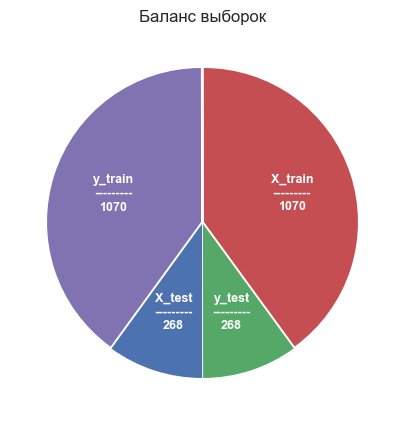

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_train_test_split_balance(X_train, X_test, y_train, y_test, startangle=234).show()

## Моделирование

[↑ contents](#contents)

<h3 id='linreg'>Простая линейная регрессия</h3>

Обучите модель линейной регрессии аналитическим методом (`LinearRegression`) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (`intercept`) обученной модели? Ответ округлите до сотых.

In [8]:
simple_linreg = linear_model.LinearRegression().fit(X_train, y_train)

pd.DataFrame(np.append(np.round(simple_linreg.intercept_, 2), np.round(simple_linreg.coef_, 2)), 
             index=np.append(['intercept'], simple_linreg.feature_names_in_),
             columns=['Linreg_params'])

,Linreg_params
intercept,-12390.80
age,256.98
sex,-18.59
bmi,337.09
children,425.28
smoker,23651.13
region_northeast,459.59
region_northwest,88.91
region_southeast,-198.28
region_southwest,-350.21


С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики: $R^{2}$, $MAE$, $MAPE$. Не забудьте привести значение $MAPE$ к процентам.

Значение $R^{2}$ округлите до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$ — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [9]:
y_train_pred = simple_linreg.predict(X_train)
y_test_pred = simple_linreg.predict(X_test)

metrics_for_this_cell = print_metrics(y_train=y_train, y_test=y_test,
                                      y_train_pred=[y_train_pred],
                                      y_test_pred=[y_test_pred],
                                      list_of_metrics=['r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'], names=['']).T

metrics_for_this_cell['MAPE'] = metrics_for_this_cell['MAPE'] * 100
metrics_for_this_cell.apply(lambda x: x.round(3) if x.name == 'r2' else x.round().astype(int))

,,r2,MAE,MAPE
train,,0.742,4208,42
test,,0.784,4181,47


Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: y−ˆy (без модуля).

Выберите верные ответы:

* A Разброс ошибок на тестовой выборке больше, чем на тренировочной.
* <font color=green>B</font> Разброс ошибок на тренировочной выборке больше, чем на тестовой.
* <font color=green>C</font> Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).
* D Медианная ошибка на тренировочной и тестовой выборках положительная (больше 0) 

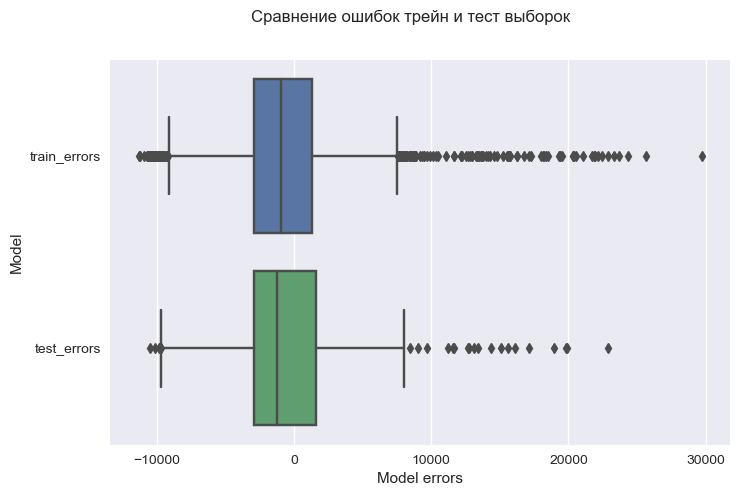

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

fig.suptitle('Сравнение ошибок трейн и тест выборок')
ax.set_xlabel('Model errors')
ax.set_ylabel('Model')

sns.boxplot(pd.DataFrame({'train_errors': y_train-y_train_pred, 'test_errors': y_test-y_test_pred}), ax=ax, orient='h')

plt.show()

[↑ contents](#contents)

<h3 id='minmaxvspoly'>Нормализация и создание полиномиальных признаков</h3>

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (`MinMaxScaler`). Расчёт параметров нормализации (`fit`) произведите на тренировочной выборке.

<div style="background: #e0fff3; color: #000; border-left: 6px solid green; text-align:left; vertical-align: middle; padding:15px 20px 3px; width: auto;">

<b>Примечание</b>. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.
</div>

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом `PolynomialFeatures` из библиотеки `sklearn`. Значение параметра `include_bias` выставите на `False`.

Чему равно результирующее количество столбцов?

In [13]:
scaler_6_5 = preprocessing.MinMaxScaler().fit(X_train)

X_train_scaled = scaler_6_5.transform(X_train)
X_test_scaled = scaler_6_5.transform(X_test)

poly_load = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly_load.fit_transform(X_train_scaled)
X_test_poly = poly_load.fit_transform(X_test_scaled)

print(X_train_poly.shape, X_test_poly.shape)

(1070, 54) (268, 54)


[↑ contents](#contents)

<h3 id='linregpoly'>Линейная регрессия на полиномиальных признаках</h3>

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики $R^{2}$ на тестовой выборке?

Значение $R^{2}$ округлите до трёх знаков после запятой.

In [14]:
linreg_poly = linear_model.LinearRegression().fit(X_train_poly, y_train)

y_train_pred_poly = linreg_poly.predict(X_train_poly)
y_test_pred_poly = linreg_poly.predict(X_test_poly)

metrics_for_this_cell = print_metrics(y_train=y_train, y_test=y_test,
                                      y_train_pred=[y_train_pred_poly],
                                      y_test_pred=[y_test_pred_poly],
                                      list_of_metrics=['r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'], names=['']).T

metrics_for_this_cell['MAPE'] = metrics_for_this_cell['MAPE'] * 100
metrics_for_this_cell.apply(lambda x: x.round(3) if x.name == 'r2' else x.round().astype(int))

,,r2,MAE,MAPE
train,,0.842,2908,29
test,,0.866,2747,30


Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

<font color=green>Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация. </font>

In [15]:
linreg_poly.coef_

array([-2.33028309e+16,  2.12499672e+15,  6.75959877e+14,  3.29810193e+15,
        4.54586897e+15, -3.26490013e+16,  8.42194047e+15,  5.43379764e+16,
        7.00548945e+15,  8.39200000e+03,  8.09000000e+02,  9.28000000e+02,
       -1.67600000e+03,  1.58000000e+02,  2.33028309e+16,  2.33028309e+16,
        2.33028309e+16,  2.33028309e+16, -2.85049214e+15,  6.77750000e+02,
       -1.24375000e+03,  2.16875000e+02,  7.25495424e+14,  7.25495424e+14,
        7.25495424e+14,  7.25495424e+14, -9.64040625e+03,  1.56068750e+03,
        5.47871250e+04, -6.75959877e+14, -6.75959877e+14, -6.75959877e+14,
       -6.75959877e+14, -2.09600000e+03, -2.23800000e+03, -3.29810193e+15,
       -3.29810193e+15, -3.29810193e+15, -3.29810193e+15,  6.98822140e+14,
       -5.24469111e+15, -5.24469111e+15, -5.24469111e+15, -5.24469111e+15,
        4.38679470e+16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.79700521e+15,  0.00000000e+00,  0.00000000e+00, -4.31190307e+16,
        0.00000000e+00,  

[↑ contents](#contents)

<h3 id='lassopoly'>Lasso регрессия на полиномиальных признаках</h3>

Постройте линейную регрессию с L1-регуляризацией (`Lasso`) на полиномиальных признаках. В качестве параметра `alpha` используйте значение по умолчанию, параметр `max_iter` установите в значение 2000.

Чему равны метрики R2, MAE и MAPE на тестовой выборке?

Значение R2 округлите до трёх знаков после запятой, а значения MAE и MAPE до целого числа.

Посмотрите на степени параметров модели после регуляризации. Сделайте вывод для себя.  
Вывод: параметры пришли к нормальным значениям, что говорит об устойчивости модели.

In [16]:
lasso_model = linear_model.Lasso(max_iter=2000).fit(X_train_poly, y_train)

y_train_pred_poly_lasso = lasso_model.predict(X_train_poly)
y_test_pred_poly_lasso = lasso_model.predict(X_test_poly)

lasso_metrics = print_metrics(y_train=y_train, y_test=y_test,
                              y_train_pred=[y_train_pred_poly_lasso],
                              y_test_pred=[y_test_pred_poly_lasso],
                              list_of_metrics=['r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'], names=['']).T

lasso_metrics['MAPE'] = lasso_metrics['MAPE'] * 100
lasso_metrics = lasso_metrics.apply(lambda x: x.round(3) if x.name == 'r2' else x.round().astype(int))

display(lasso_metrics)
print(lasso_model.coef_)

,,r2,MAE,MAPE
train,,0.842,2890,29
test,,0.867,2719,30


[ 3.24221653e+03 -4.92313816e+02  5.07612317e+03  4.58362056e+03
  1.97928569e+03  1.88025707e+02 -4.70775218e+02  5.83657101e+02
 -2.43543456e+02  8.29826751e+03  7.74581954e+02  8.44448593e+02
 -1.20775688e+03  1.34809915e+02 -1.04309726e+03 -0.00000000e+00
  1.16964229e+03  1.61765564e+03 -0.00000000e+00  5.05847740e+02
 -1.13425152e+03  2.65796922e+02 -1.22240479e+03  0.00000000e+00
  2.36213242e+02 -5.80031340e+02 -8.17963257e+03  1.29487768e+03
  5.47148553e+04  3.58531873e+03  2.40690210e+03 -9.63549427e+02
  0.00000000e+00 -1.67464337e+03 -2.05436459e+03  1.94204864e+03
  1.95394442e+03 -0.00000000e+00 -1.06364416e+03  8.00606774e+00
  5.93688978e+02 -0.00000000e+00 -2.30643423e+02  1.97933477e+03
  6.31615519e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.05849873e-01]


[↑ contents](#contents)

<h3 id='ridgepoly'>Ridge регрессия на полиномиальных признаках</h3>

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра `alpha` используйте значение по умолчанию.

Чему равны метрики R2, MAE и MAPE на тестовой выборке?

Значение R2 округлите до трёх знаков после запятой, а значения MAE и MAPE до целого числа.

In [17]:
ridge_model = linear_model.Ridge().fit(X_train_poly, y_train)

y_train_pred_poly_ridge = ridge_model.predict(X_train_poly)
y_test_pred_poly_ridge = ridge_model.predict(X_test_poly)

metrics_for_this_cell = print_metrics(y_train=y_train, y_test=y_test,
                                      y_train_pred=[y_train_pred_poly_ridge],
                                      y_test_pred=[y_test_pred_poly_ridge],
                                      list_of_metrics=['r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'], names=['']).T

metrics_for_this_cell['MAPE'] = metrics_for_this_cell['MAPE'] * 100
display(metrics_for_this_cell.apply(lambda x: x.round(3) if x.name == 'r2' else x.round().astype(int)))
print(lasso_model.coef_)

,,r2,MAE,MAPE
train,,0.839,2949,30
test,,0.863,2861,31


[ 3.24221653e+03 -4.92313816e+02  5.07612317e+03  4.58362056e+03
  1.97928569e+03  1.88025707e+02 -4.70775218e+02  5.83657101e+02
 -2.43543456e+02  8.29826751e+03  7.74581954e+02  8.44448593e+02
 -1.20775688e+03  1.34809915e+02 -1.04309726e+03 -0.00000000e+00
  1.16964229e+03  1.61765564e+03 -0.00000000e+00  5.05847740e+02
 -1.13425152e+03  2.65796922e+02 -1.22240479e+03  0.00000000e+00
  2.36213242e+02 -5.80031340e+02 -8.17963257e+03  1.29487768e+03
  5.47148553e+04  3.58531873e+03  2.40690210e+03 -9.63549427e+02
  0.00000000e+00 -1.67464337e+03 -2.05436459e+03  1.94204864e+03
  1.95394442e+03 -0.00000000e+00 -1.06364416e+03  8.00606774e+00
  5.93688978e+02 -0.00000000e+00 -2.30643423e+02  1.97933477e+03
  6.31615519e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.05849873e-01]


## Дополнительное исследование

[↑ contents](#contents)

<h3 id='ridgepolylogtarget'>RidgeCV регрессия на полиномиальных признаках и логарифмированном таргете</h3>

Что здесь может быть интересно:
- помимо изначального преобразования признаков `sex` и `smoker` в бинарные,
- были добавлены признаки:
    * степени ожирения,
    * `age` > 60;
- так же был логарифмирован таргет, т.к. он логнормальный;
- был использован параметр `interaction_only=True`, что означает, что класс `PolynomialFeatures` создаёт зависимости между признаками, без возведения в степень;
- была использована модель `RidgeCV` с расширенным списком параметра `alpha`;
- так же в качестве кросс валидатора был использован `KFold`, но скорее всего он был лишним.

In [18]:
model_df_2 = incoming_df.copy()

# Обновление признаков и добавление нескольких новых.
model_df_2['sex'] = model_df_2['sex'].apply(lambda x: 1 if x == 'male' else 0)
model_df_2['smoker'] = model_df_2['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

model_df_2['obese'] = (model_df_2['bmi'] > 30).astype(int)
model_df_2['old'] = (model_df_2['age'] >= 60).astype(int)

# Логарифмирование таргета.
X_2 = model_df_2.drop(['charges', 'region'], axis=1)
y_2 = np.log1p(model_df_2['charges'])

# Разбиение выборки на трейн и тест.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.23, random_state=42)

#######################
# Нормирование признаков и создание зависимостей признаков без возвередния в степень, interaction_only.

scaler_2 = preprocessing.MinMaxScaler().fit(X_train_2)

X_train_2_scaled = scaler_2.transform(X_train_2)
X_test_2_scaled = scaler_2.transform(X_test_2)

poly_load_2 = preprocessing.PolynomialFeatures(degree=5, include_bias=False, interaction_only=True).fit(X_train_2_scaled)

X_train_2_poly = poly_load_2.transform(X_train_2_scaled)
X_test_2_poly = poly_load_2.transform(X_test_2_scaled)

#######################
# Обучение модели и подсчёт метрик в разлогарифмированных предсказаниях.

ridgecv_model = linear_model.RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=KFold(n_splits=5, shuffle=True, random_state=42)).fit(X_train_2_poly, y_train_2)

y_train_2_pred_poly = ridgecv_model.predict(X_train_2_poly)
y_test_2_pred_poly = ridgecv_model.predict(X_test_2_poly)

metrics_for_this_cell = print_metrics(y_train=np.expm1(y_train_2), y_test=np.expm1(y_test_2),
                                      y_train_pred=[np.expm1(y_train_2_pred_poly)],
                                      y_test_pred=[np.expm1(y_test_2_pred_poly)],
                                      list_of_metrics=['r2_score', 'mean_absolute_error', 'mean_absolute_percentage_error'], names=['']).T

metrics_for_this_cell['MAPE'] = metrics_for_this_cell['MAPE'] * 100
metrics_for_this_cell.apply(lambda x: x.round(3) if x.name == 'r2' else x.round().astype(int))

,,r2,MAE,MAPE
train,,0.865,1934,16
test,,0.878,1889,16


Так же можно взглянуть на анализ мультиколинеарности:

In [19]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_2.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_2.values, i) for i in range(X_train_2.shape[1])]
print(vif_data.sort_values("VIF", ascending=False))

    feature        VIF
2       bmi  15.748941
0       age  10.707709
5     obese   3.404816
1       sex   2.004094
3  children   1.878238
6       old   1.450974
4    smoker   1.258924


Что можно наблюдать?  
- `r2` 0.86 и 0.87, что означает, что модель хорошо объясняет дисперсию таргета и не переобучается;
- мультиколинеарности нет, `bmi` и `age` на грани, но приемлемо;
- модель стабильна и показывает прекрасные результаты.

Думаю, бессмысленно сравнивать результаты с предыдущими моделями, т.к. они были простыми, без особых заморочек.

Что ещё можно посмотреть? Важность признаков, к примеру:

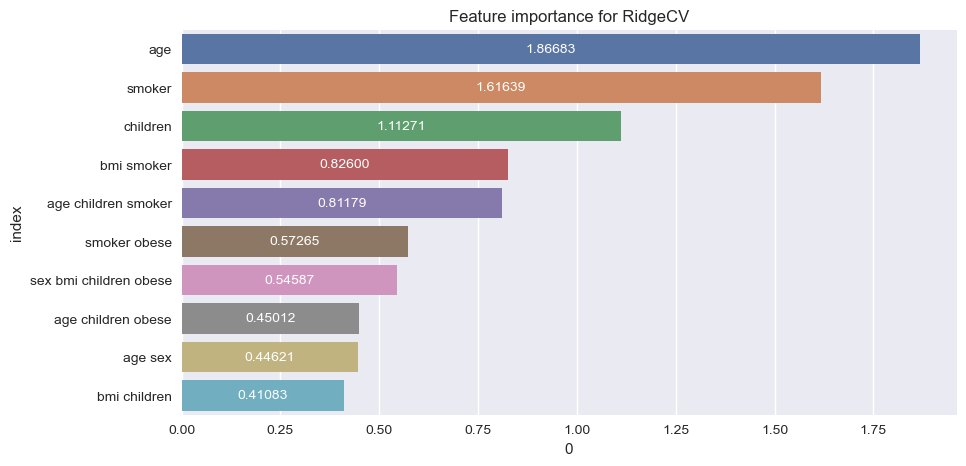

In [20]:
df_for_this_cell = pd.Series(ridgecv_model.coef_, index=poly_load_2.get_feature_names_out(X_2.columns)).sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(df_for_this_cell.reset_index(), x=0, y='index', palette='deep')
ax.bar_label(ax.containers[0], fmt='%.5f', label_type='center', color='white')
ax.set_title('Feature importance for RidgeCV')

plt.show()

А так же на ошибки трейна и теста:

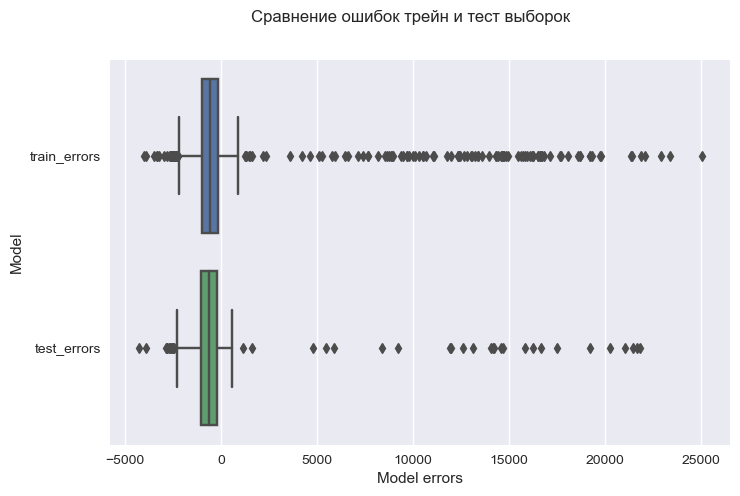

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

fig.suptitle('Сравнение ошибок трейн и тест выборок')
ax.set_xlabel('Model errors')
ax.set_ylabel('Model')

sns.boxplot(pd.DataFrame({'train_errors': np.expm1(y_train_2) - np.expm1(y_train_2_pred_poly), 'test_errors': np.expm1(y_test_2) - np.expm1(y_test_2_pred_poly)}), ax=ax, orient='h')

plt.show()

Коробки узкие, 75 квантиль в нуле, усы короткие. Выбросы - выбросы.
- Основная масса ошибок модели находится в очень узком диапазоне — значит, модель предсказывает стабильно.
- Модель очень хорошо предсказывает бОльшую часть выборки.
- Почти все ошибки (кроме выбросов) сконцентрированы близко к медиане. Ошибки почти не разбросаны.

[↑ contents](#contents)